# FACT-UVA: Man is to Programmer as Woman is to Homemaker?

## Links

Debiaswe: https://github.com/tolga-b/debiaswe
Lipstick: https://github.com/gonenhila/gender_bias_lipstick

### How to get the GoogleNews word2vec embeddings:
Download it directly from the official [website](https://code.google.com/archive/p/word2vec/) or clone [this github repo](https://github.com/mmihaltz/word2vec-GoogleNews-vectors). Place the downloaded **.bin** file in the embeddings folder.

### How to get the Glove embeddings:
Go to the official [website](https://nlp.stanford.edu/projects/glove/). Download **glove.840B.300d.zip**. Place the downloaded **.txt** file in the embeddings folder.

## Debiasing Word Embeddings

### Word2vec

The code block bellow executes the main debias function using the word2vec Google News embeddings. Additionally, the function takes as arugments several json files with definitional pairs and geneder specific words as described in the original paper. The function outputs two files - **bias_word2vec.bin** and **debiased_word2vec.bin**, which correspond to the embeddings before and after debiasing. One of the input JSON files is also a list of professions. Setting the parameter **--load_profs** to True replicates Figure 3 from the original paper, i.e. prints the top 5 professions furthest away from the default softball-football axis when projected onto said axis both before and after debiasing.

In [1]:
# Debias word2vec embeddings
!cd code && python3 main.py --debias_o_em=../embeddings/debiased_word2vec.bin --bias_o_em=../embeddings/bias_word2vec.bin --load_profs=True

*** Reading data from ../embeddings/GoogleNews-vectors-negative300.bin
Number of words:  26391
Saving biased vectors to file...

   Before debiasing
   softball extreme        	football extreme
1. bookkeeper             	footballer
2. receptionist           	businessman
3. registered_nurse       	pundit
4. waitress               	maestro
5. homemaker              	cleric


Debiasing...
Saving debiased vectors to file...

   After debiasing
   softball extreme        	football extreme
1. infielder              	footballer
2. major_leaguer          	lecturer
3. investigator           	pundit
4. attorney               	midfielder
5. trooper                	fashion_designer


Done!



### Glove

The only difference between the two formats (word2vec and glove) is that the first line of word2vec contains the number of words and the vector size, while glove does no contain said line. In order to simplify things and reduce the lenght of the code we can convert one of the two to the other format. This way the code has to supoort only one format. The code block below converts the glove embeddings to the word2vec fromat (**May take some time**). Said code block needs to be executed only once.

In [2]:
# convert glove to word2vec format
!cd code/scripts && ./gloveToW2V.sh ../../embeddings/glove.840B.300d.txt ../../embeddings/glove.formatted.txt

extracting number of vectors
there are 2196017 lines
extracting vector dimension
cat: write error: Broken pipe
vectors have size 300
creating word2vec format file
done


After transforming the glove embeddings to the word2vec format we can rerun the previous experiment this time using the glove embeddings. The function will generate two files again - **bias_glove.bin** and **debiased_glove.bin** respectfully.

In [3]:
# Debias glove embeddings
!cd code && python3 main.py --i_em=../embeddings/glove.formatted.txt --debias_o_em=../embeddings/debiased_glove.bin --bias_o_em=../embeddings/bias_glove.bin --load_profs=True

*** Reading data from ../embeddings/glove.formatted.txt
Number of words:  23177
Saving biased vectors to file...

   Before debiasing
   softball extreme        	football extreme
1. counselor              	footballer
2. paralegal              	boss
3. nurse                  	politician
4. realtor                	coach
5. ranger                 	midfielder


Debiasing...
Saving debiased vectors to file...

   After debiasing
   softball extreme        	football extreme
1. ranger                 	footballer
2. warden                 	boss
3. counselor              	politician
4. superintendent         	coach
5. trooper                	substitute


Done!



## Benchmark debiased embeddings

To install the benchmarking library

In [4]:
!cd code/benchmark && python3 setup.py install

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/distutils/dist.py:261: UserWarning: Unknown distribution option: 'extra_files'
  warnings.warn(msg)
running install
running bdist_egg
running egg_info
writing top-level names to web.egg-info/top_level.txt
writing requirements to web.egg-info/requires.txt
writing web.egg-info/PKG-INFO
writing dependency_links to web.egg-info/dependency_links.txt
reading manifest file 'web.egg-info/SOURCES.txt'
writing manifest file 'web.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/web
copying build/lib/web/vocabulary.py -> build/bdist.linux-x86_64/egg/web
copying build/lib/web/evaluate.py -> build/bdist.linux-x86_64/egg/web
copying build/lib/web/embedding.py -> build/bdist.linux-x86_64/egg/web
copying build/lib/web/version.py -> build/bdist.linux-x86_64/egg/web
creating build/bdist.linux-x86_64/egg/web/_utils

In [5]:
!cd code/benchmark/scripts/ && ./run_test.sh

10:36:59 INFO:loading projection weights from /home/daddabarba/Repos/FACT-UVA/embeddings/bias_word2vec.bin
10:36:59 INFO:Loading #26391 words with 300 dim
10:36:59 INFO:Transformed 26391 into 26391 words
10:36:59 INFO:Calculating similarity benchmarks
10:36:59 WARNING:Missing 12 words. Will replace them with mean vector
10:36:59 INFO:Spearman correlation of scores on RG65 0.6937745222655595
10:36:59 WARNING:Missing 528 words. Will replace them with mean vector
10:36:59 INFO:Spearman correlation of scores on MEN 0.70422556229531
10:36:59 WARNING:Missing 17 words. Will replace them with mean vector
10:36:59 INFO:Spearman correlation of scores on SimLex999 0.43510114901981567
10:36:59 WARNING:Missing 41 words. Will replace them with mean vector
10:36:59 INFO:Spearman correlation of scores on WS353 0.6488884094043214
10:36:59 WARNING:Missing 23 words. Will replace them with mean vector
10:36:59 INFO:Spearman correlation of scores on WS353R 0.5805558093795756
10:36:59 WARNING:Missing 1924 w

In [6]:
# show results
import csv
from tabulate import tabulate
from statistics import variance as var

def show_benchmarks(file):
    with open(file, 'r') as f:
        rows = list(csv.reader(f))[:-1]
        rows = [list(x) for x in zip(*rows)]
        
    rows[0].append('VARIANCE')
    for row in rows[1:]:
        vals = [float(x) for x in row[1:]]
        row.append(var(vals))
        
    print(tabulate(rows[1:], headers=rows[0]))
    
show_benchmarks('./code/benchmark/scripts/result.csv')

Name             bias_word2vec    debiased_word2vec    bias_glove    debiased_glove     VARIANCE
-------------  ---------------  -------------------  ------------  ----------------  -----------
AP                    0.557214             0.534826      0.532338          0.539801  0.000125822
BLESS                 0.67                 0.67          0.755             0.73      0.00185625
Battig                0.235519             0.23571       0.27662           0.264577  0.000432135
ESSLI_1a              0.75                 0.818182      0.795455          0.75      0.00116219
ESSLI_2b              0.8                  0.775         0.75              0.75      0.000572917
ESSLI_2c              0.644444             0.622222      0.622222          0.622222  0.000123457
MEN                   0.704226             0.707754      0.76402           0.774168  0.00134662
MTurk                 0.513563             0.512081      0.640383          0.634095  0.00516682
RG65                  0.693775    

## Generating analogies

Once we have tested that the main properties of the embeddings are still in the debiased ones, then we can generate `he:she = x:y` analogies, and observe the resulting `x:y`  pairs.

### Defining list of x for `he:she = x:y` analogies
We will now define a list of third words `x` such that they can be used to find a fourth one `y` by completing the analogy `he:she = x:y` 

In [7]:
import json

words = [
    "footbaler",
    "programmer",
    "soldier",
    "professor",
    "doctor",
    "captain",
    "coach"
]

with open('./code/analogies/z_words.json', 'w') as f:
    json.dump(words, f)

### Analogies for original word2vec

In [8]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_bias_word2vec.txt --i_em ../../embeddings/bias_word2vec.bin --pair_seed he-she --z_file z_words.json

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:109: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like programmer is to graphic_designer
he is to she like soldier is to servicemen
he is to she like professor is to assistant_professor
he is to she like doctor is to nurse
he is to she like captain is to captains
he is to she like coach is to basketball


### Analogies for Debiased word2vec

In [9]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_debiased_word2vec.txt --i_em ../../embeddings/debiased_word2vec.bin --pair_seed he-she --z_file z_words.json

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:109: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like programmer is to graphic_designer
he is to she like soldier is to comrade
he is to she like professor is to sociologist
he is to she like doctor is to dermatologist
he is to she like captain is to skipper
he is to she like coach is to coaching


### Analogies original glove

In [10]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_bias_glove.txt --i_em ../../embeddings/bias_glove.bin --pair_seed he-she --z_file z_words.json

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:109: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like programmer is to freelance
he is to she like soldier is to brave
he is to she like professor is to librarian
he is to she like doctor is to pregnant
he is to she like captain is to sailor
he is to she like coach is to volleyball


### Analogies debiased glove

In [11]:
!cd ./code/analogies/ && python3 analogies.py --pairs_fname pairs_debiased_glove.txt --i_em ../../embeddings/debiased_glove.bin --pair_seed he-she --z_file z_words.json

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
analogies.py:109: RuntimeWarning: invalid value encountered in true_divide
  analogies_dir = analogies/norms[:, None] # Directions
he is to she like programmer is to programmers
he is to she like soldier is to troop
he is to she like professor is to grad
he is to she like doctor is to therapist
he is to she like captain is to sailor
he is to she like coach is to coaching


## Testing Debiasing (Lipstick on a Pig)
Besides generating analogies, we can also test the effects of debiasing quantitatively. For that we chose the classification task from the original paper, and extended it to run on 3 different classifiers (SVM-RBF, Logistic regression, MLP), iteratively expanding the size of the training set. The plot reports the average accuracies of 3 runs with different random seeds.

In [12]:
%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import json
import os 


In [13]:
def plot_results(results, embeddings, direction = "horizontal"):
    ## plotting results
    
    splits = results["splits"]
    
    if direction == "horizontal":
        fig,a =	 plt.subplots(1, 3)
        fig.set_figwidth(15)
        plt.suptitle("Classification results - " + embeddings)

    else:
        fig,a =	 plt.subplots(3)
        fig.set_figheight(15)
    a[0].set_title("Classification on original embeddings")
    a[0].set_xlabel('training data used (portion)')
    a[0].set_ylabel('accuracy')
    a[0].set_ylim(0.7, 1.05)
    a[1].set_title("Classification on debiased embeddings")
    a[1].set_xlabel('training data used (portion)')
    a[1].set_ylabel('accuracy')
    a[1].set_ylim(0.7, 1.05)
    a[2].set_title("Difference: original - debiased")
    a[2].set_xlabel('training data used (portion)')
    a[2].set_ylabel('accuracy difference')
    for accuracy in results["accuracies_bef"]:
        a[0].plot(splits, accuracy)
    for accuracy in results["accuracies_aft"]:
        a[1].plot(splits, accuracy)	 
    for accuracy in results["acc_diffs"]:
        a[2].plot(splits, accuracy)
    plt.legend(results["classifier_names"])
    plt.show()

### Word2Vec

Run the classifiers with increasing data size (10 runs with different seeds)

In [14]:
!cd ./code/lipstick/ && python3 classify_debiased.py --embeddings_original=../../embeddings/bias_word2vec.bin --embeddings_debiased=../../embeddings/debiased_word2vec.bin --fname=w2v

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  26391
Number of words:  26391
loading done
0.04705043832121202
0.002165146604663836
================SVM-RBF================
classifier done
Figure(1500x480)


Show accuracies

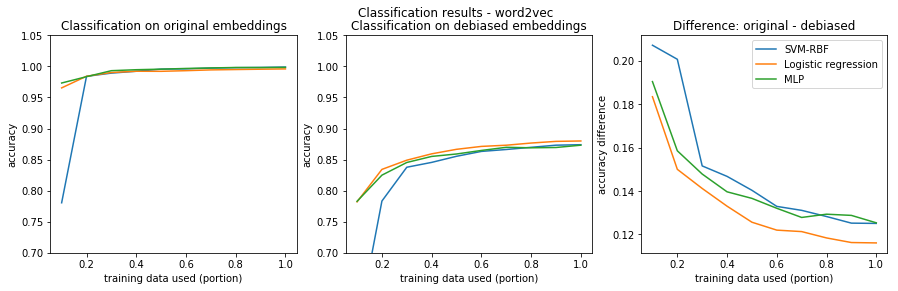

In [ ]:
file = open('./code/lipstick//results/results_w2v')
results_js = file.read()
results = json.loads(results_js)
plot_results(results, "word2vec")

### Glove

Run the classifiers with increasing data size (10 runs with different seeds)

In [ ]:
!cd ./code/lipstick/ && python3 classify_debiased.py --embeddings_original=../../embeddings/bias_glove.bin --embeddings_debiased=../../embeddings/debiased_glove.bin --fname=glove

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  23177
Number of words:  23177
loading done
0.039783456692988134
0.001811158709247648
================SVM-RBF================
classifier done
================Logistic regression================
classifier done
================MLP================
/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
classifier done
Figure(1500x480)


Show accuracies

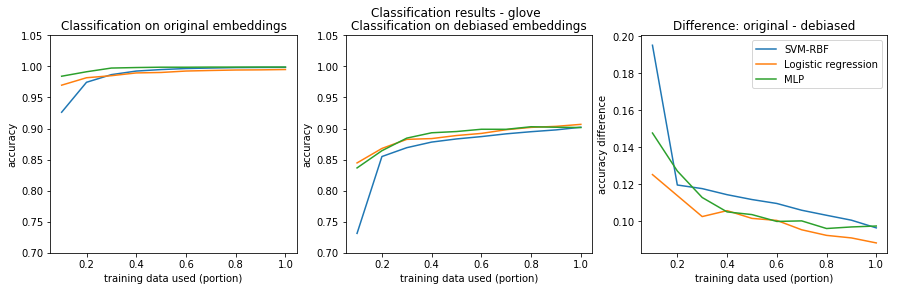

In [ ]:
file = open('./code/lipstick//results/results_glove')
results_js = file.read()
results = json.loads(results_js)
plot_results(results, "glove")

### Removing remaining bias
To remove the subtle bias from the original embeddings, we run the debiasing again, but instead of selecting a single principal component for the subspace, we select all available (18) components and neutralize according to that

debiasing using all components:

In [ ]:
!cd code && python3 main.py --debias_o_em=../embeddings/debiased_word2vec_all_pca.bin --bias_o_em=../embeddings/bias_word2vec_all_pca.bin --load_profs=True --n_comp=18

*** Reading data from ../embeddings/GoogleNews-vectors-negative300.bin
Number of words:  26391
Saving biased vectors to file...

   Before debiasing
   softball extreme        	football extreme
1. bookkeeper             	footballer
2. receptionist           	businessman
3. registered_nurse       	pundit
4. waitress               	maestro
5. homemaker              	cleric


Debiasing...
Saving debiased vectors to file...

   After debiasing
   softball extreme        	football extreme
1. infielder              	footballer
2. investigator           	lecturer
3. major_leaguer          	fashion_designer
4. trooper                	midfielder
5. attorney               	pundit


Done!



Benchmarking

In [ ]:
!CWD=$(pwd) && cd ./code/benchmark/scripts && python3 evaluate_on_all.py -f $CWD/embeddings/debiased_word2vec_all_pca.bin

10:44:15 INFO:loading projection weights from /home/daddabarba/Repos/FACT-UVA/embeddings/debiased_word2vec_all_pca.bin
10:44:15 INFO:Loading #26391 words with 300 dim
10:44:15 INFO:Transformed 26391 into 26391 words
10:44:15 INFO:Calculating similarity benchmarks
10:44:15 WARNING:Missing 528 words. Will replace them with mean vector
10:44:15 INFO:Spearman correlation of scores on MEN 0.7072549563178232
10:44:15 WARNING:Missing 1924 words. Will replace them with mean vector
10:44:15 INFO:Spearman correlation of scores on RW 0.2914499172907636
10:44:15 WARNING:Missing 105 words. Will replace them with mean vector
10:44:15 INFO:Spearman correlation of scores on MTurk 0.5122517474383192
10:44:15 WARNING:Missing 17 words. Will replace them with mean vector
10:44:15 INFO:Spearman correlation of scores on SimLex999 0.4428569830105823
10:44:15 WARNING:Missing 25 words. Will replace them with mean vector
10:44:15 INFO:Spearman correlation of scores on WS353S 0.7106264247577048
10:44:15 WARNING:

Running the classification experiment with the new debiased embeddings

In [ ]:
!cd ./code/lipstick/ && python3 classify_debiased.py --embeddings_original=../../embeddings/bias_word2vec_all_pca.bin --embeddings_debiased=../../embeddings/debiased_word2vec_all_pca.bin --fname=w2v_all_pca

/home/daddabarba/miniconda3/envs/fact/lib/python3.5/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Number of words:  26391
Number of words:  26391
loading done
0.0470504383239646
0.0023367988494523077
================SVM-RBF================


Showing classification results

In [ ]:
file = open('./code/lipstick//results/results_w2v_all_pca')
results_js = file.read()
results = json.loads(results_js)
plot_results(results, "word2vec - all principal components")

Comparing classification performance of 1-component debiasing and 18-component debiasing

In [ ]:
file = open('./code/lipstick//results/results_w2v')
results_js = file.read()
results_1 = json.loads(results_js)

file = open('./code/lipstick//results/results_w2v_all_pca')
results_js = file.read()
results_all = json.loads(results_js)

splits = results_all["splits"]
plt.title("Accuracy after debiasing using different size of gender subspace")
plt.plot(splits, results_1["accuracies_aft"][1], label = "1D gender space")
plt.plot(splits, results_all["accuracies_aft"][1], label = "18D gender space" )
plt.legend(["1D gender space", "18D gender space"])
plt.xlabel('training data used (portion)')
plt.ylabel('accuracy')

plt.show()
